<a href="https://colab.research.google.com/github/mervenurerdogan/CA_NORMAL/blob/main/VIT_CA_NORMAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq timm

     |████████████████████████████████| 549 kB 29.5 MB/s 
     |████████████████████████████████| 182 kB 61.8 MB/s 


In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 39.3 MB/s 
     |████████████████████████████████| 451 kB 67.4 MB/s 
     |████████████████████████████████| 1.3 MB 57.7 MB/s 
     |████████████████████████████████| 5.5 MB 46.3 MB/s 
     |████████████████████████████████| 1.6 MB 51.9 MB/s 
     |████████████████████████████████| 212 kB 53.0 MB/s 
     |████████████████████████████████| 115 kB 53.9 MB/s 
     |████████████████████████████████| 127 kB 57.2 MB/s 
     |████████████████████████████████| 7.6 MB 47.2 MB/s 
Mounted at /content/gdrive


In [3]:
import timm
from fastbook import *
from fastai.vision.all import *

In [4]:
from zipfile import ZipFile
file_name='/content/gdrive/MyDrive/BinaryDataEdit.zip'

In [5]:
with ZipFile (file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [6]:
path=Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal')


In [7]:
path.ls()

(#3) [Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Train'),Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Valid'),Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test')]

In [8]:
train_fnames=get_image_files(path/'Train')
all_files=get_image_files(path)

In [9]:
from fastai.vision.augment import contrast
tfms = aug_transforms(size=224, 
                      min_scale=0.75,
                      do_flip=True,
                      flip_vert=True,
                      max_rotate=360,
                      max_warp=0,
                      max_zoom=1.1,
                      max_lighting=0.1,
                      p_lighting=0.5
                      
                      
                      )


In [10]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='Train',valid_name='Valid'),
                 get_y=parent_label,
                 item_tfms=Resize(224,method='squish'),
                 batch_tfms=tfms
                 
                 
)

In [11]:
dls=dblock.dataloaders(all_files,bs=16)


In [12]:
train_df = len(train_fnames)
print(f"There are {train_df} images")

There are 4129 images


In [13]:
valid_fnames=get_image_files(path/'Valid')
valid_df = len(valid_fnames)
print(f"There are {valid_df} images")

There are 500 images


In [14]:
test_fnames=get_image_files(path/'Test')
test_df = len(test_fnames)
print(f"There are {test_df} images")

There are 529 images


In [15]:
dls.c,len(dls.train_ds),len(dls.valid_ds)


(2, 4129, 500)

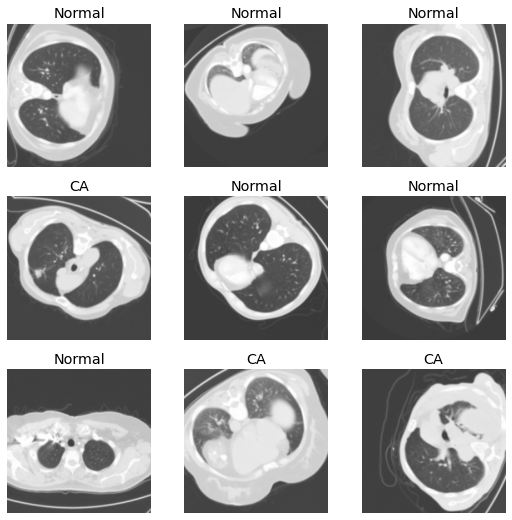

In [17]:
dls.show_batch()


In [18]:
learn = vision_learner(dls,'vit_small_patch32_224',  metrics=accuracy)


In [19]:
learn.summary()


Sequential (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 384 x 7 x 7    
Conv2d                                    1180032    False     
Identity                                                       
Dropout                                                        
Identity                                                       
LayerNorm                                 768        True      
____________________________________________________________________________
                     16 x 50 x 1152      
Linear                                    443520     False     
Dropout                                                        
Linear                                    147840     False     
Dropout                                                        
Identity                                                       
Identity                                                       
LayerNorm                 

SuggestedLRs(valley=0.0012022644514217973)

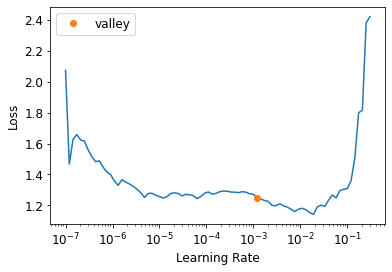

In [20]:
learn.lr_find()

In [21]:
learn.fine_tune(40,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.647827,0.516151,0.808000,01:19


epoch,train_loss,valid_loss,accuracy,time
0,0.461783,0.401289,0.830000,01:19
1,0.497643,0.404191,0.830000,01:17
2,0.431349,0.352342,0.850000,01:16
3,0.414964,0.427373,0.838000,01:20
4,0.401765,0.409755,0.842000,01:16
5,0.350448,0.424790,0.848000,01:16
6,0.336058,0.356297,0.860000,01:20
7,0.248519,0.269209,0.910000,01:15
8,0.258540,0.334894,0.880000,01:16
9,0.236745,0.373087,0.860000,01:19


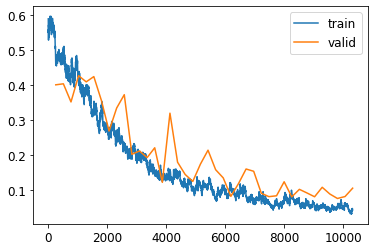

In [22]:
learn.recorder.plot_loss()


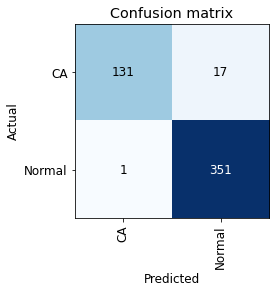

In [23]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [24]:
interp.print_classification_report()


              precision    recall  f1-score   support

          CA       0.99      0.89      0.94       148
      Normal       0.95      1.00      0.97       352

    accuracy                           0.96       500
   macro avg       0.97      0.94      0.96       500
weighted avg       0.97      0.96      0.96       500



In [25]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.9760000109672546

In [26]:
interp.most_confused()


[('CA', 'Normal', 17), ('Normal', 'CA', 1)]

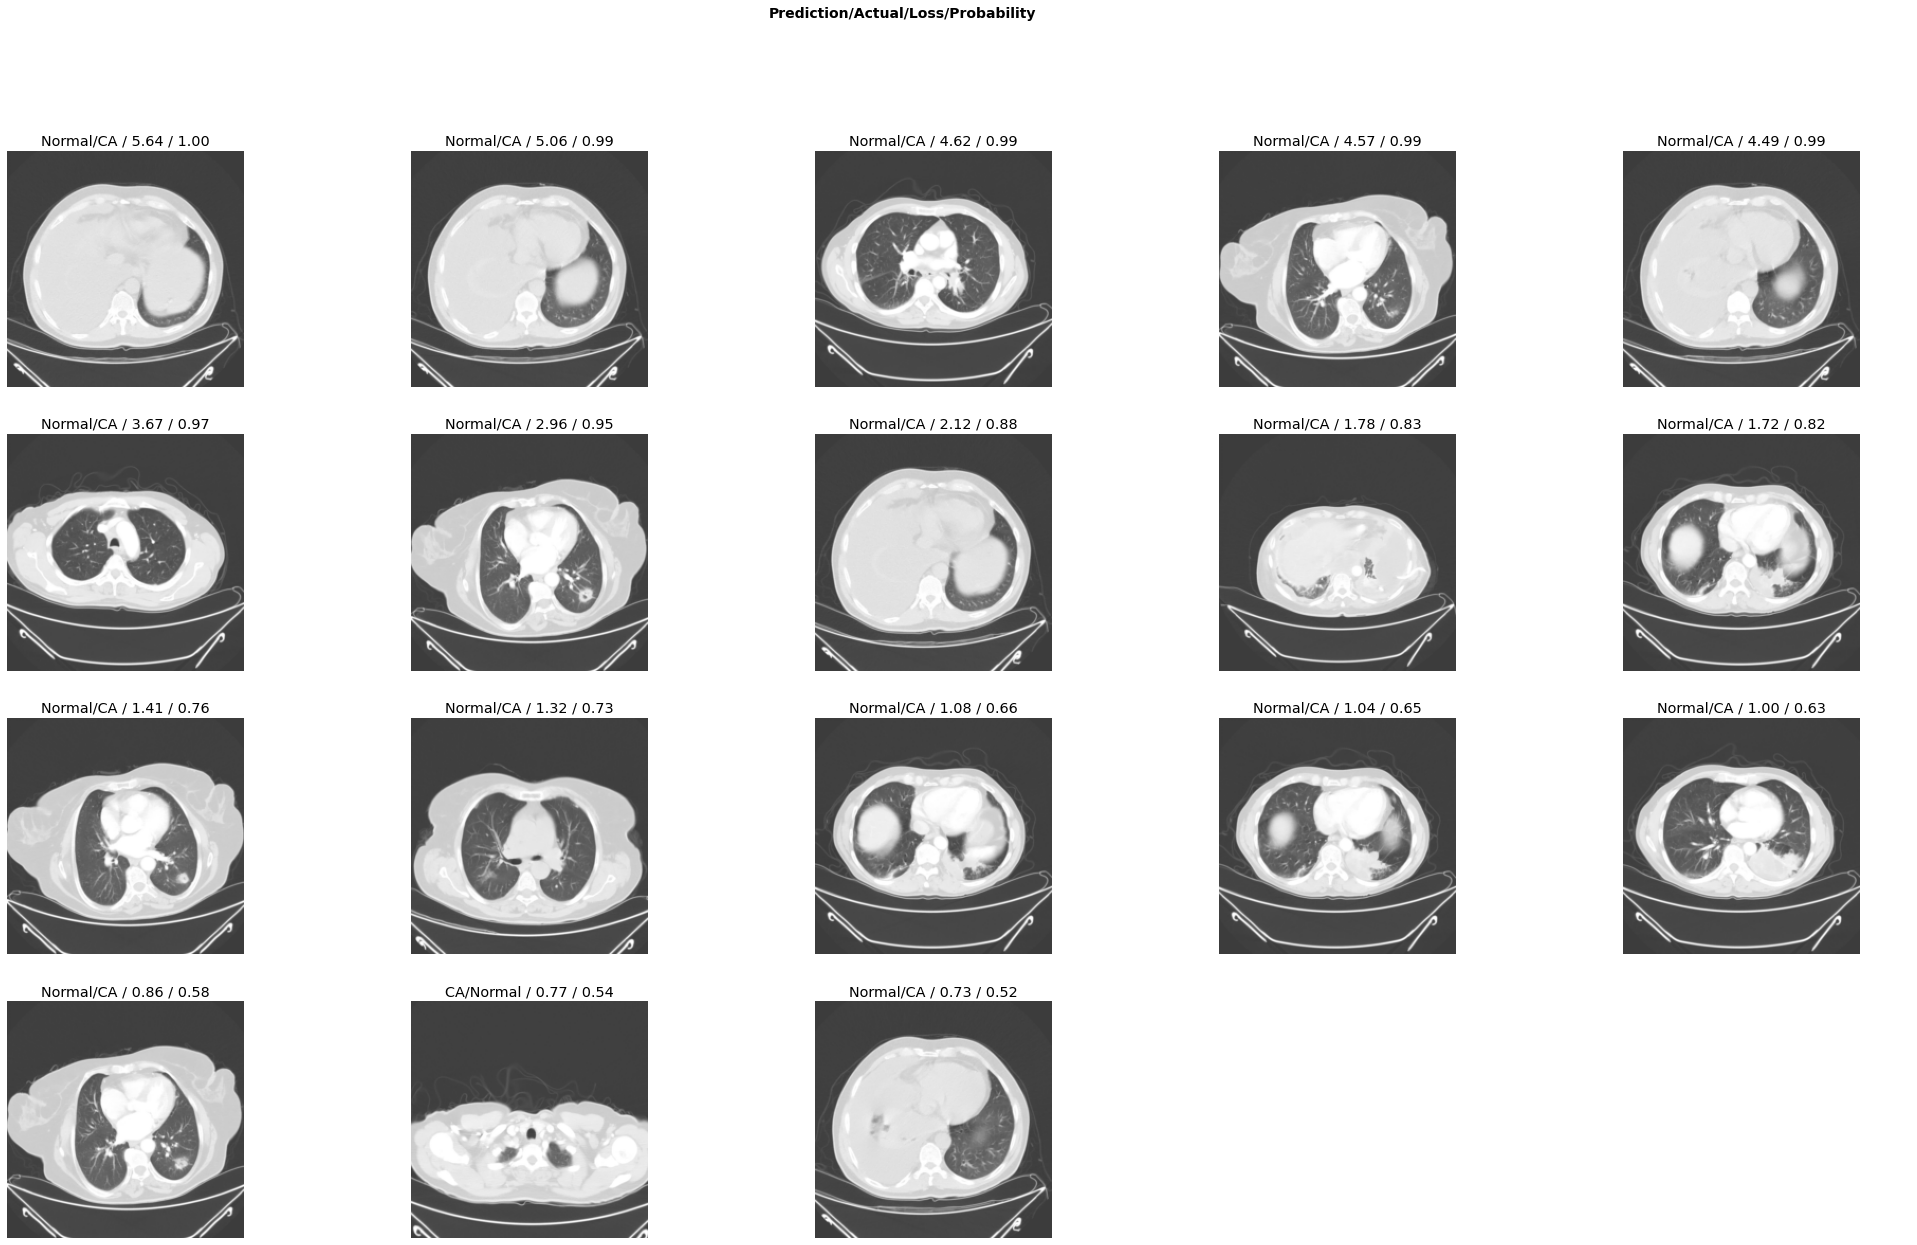

In [27]:
interp.plot_top_losses(18, figsize=(35,20))


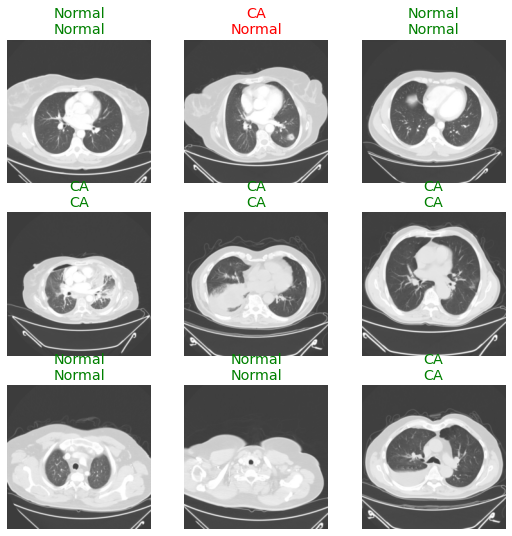

In [28]:
learn.show_results()


In [29]:
learn.save(path/'CA_Normal_Vit_Small_Train')


Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/CA_Normal_Vit_Small_Train.pth')

In [30]:
learn.export(path/'CA_Normal_Vit_Small_Train_Exp.pkl')


In [31]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='Train',valid_name='Test'),
                 get_y=parent_label,
                 item_tfms=Resize(224,method='squish'),
                 batch_tfms=tfms
                 
                 
)

In [32]:
dls_test = dblock.dataloaders(all_files)


In [33]:
learn1= learn = vision_learner(dls_test,'vit_small_patch32_224',  metrics=accuracy).load('/content/BinaryDataEdit/Lung_Binary_CA_Normal/CA_Normal_Vit_Small_Train')


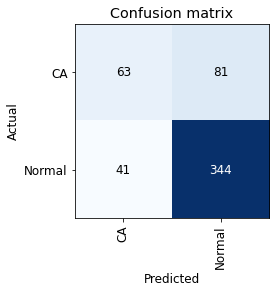

In [34]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

In [35]:
interp.print_classification_report()


              precision    recall  f1-score   support

          CA       0.61      0.44      0.51       144
      Normal       0.81      0.89      0.85       385

    accuracy                           0.77       529
   macro avg       0.71      0.67      0.68       529
weighted avg       0.75      0.77      0.76       529



In [36]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.7277882695198059

In [37]:
interp.most_confused()


[('CA', 'Normal', 81), ('Normal', 'CA', 41)]

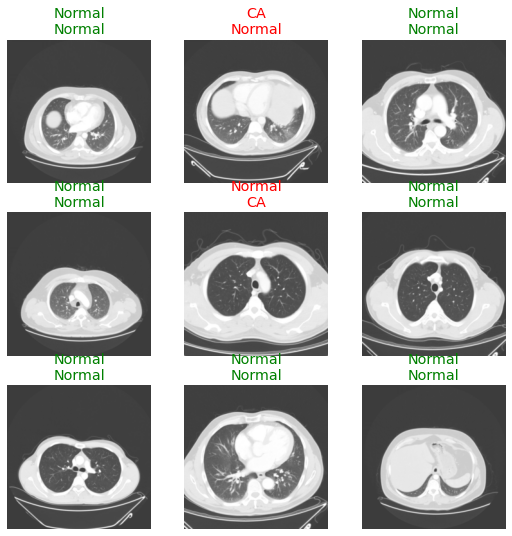

In [38]:
learn1.show_results()


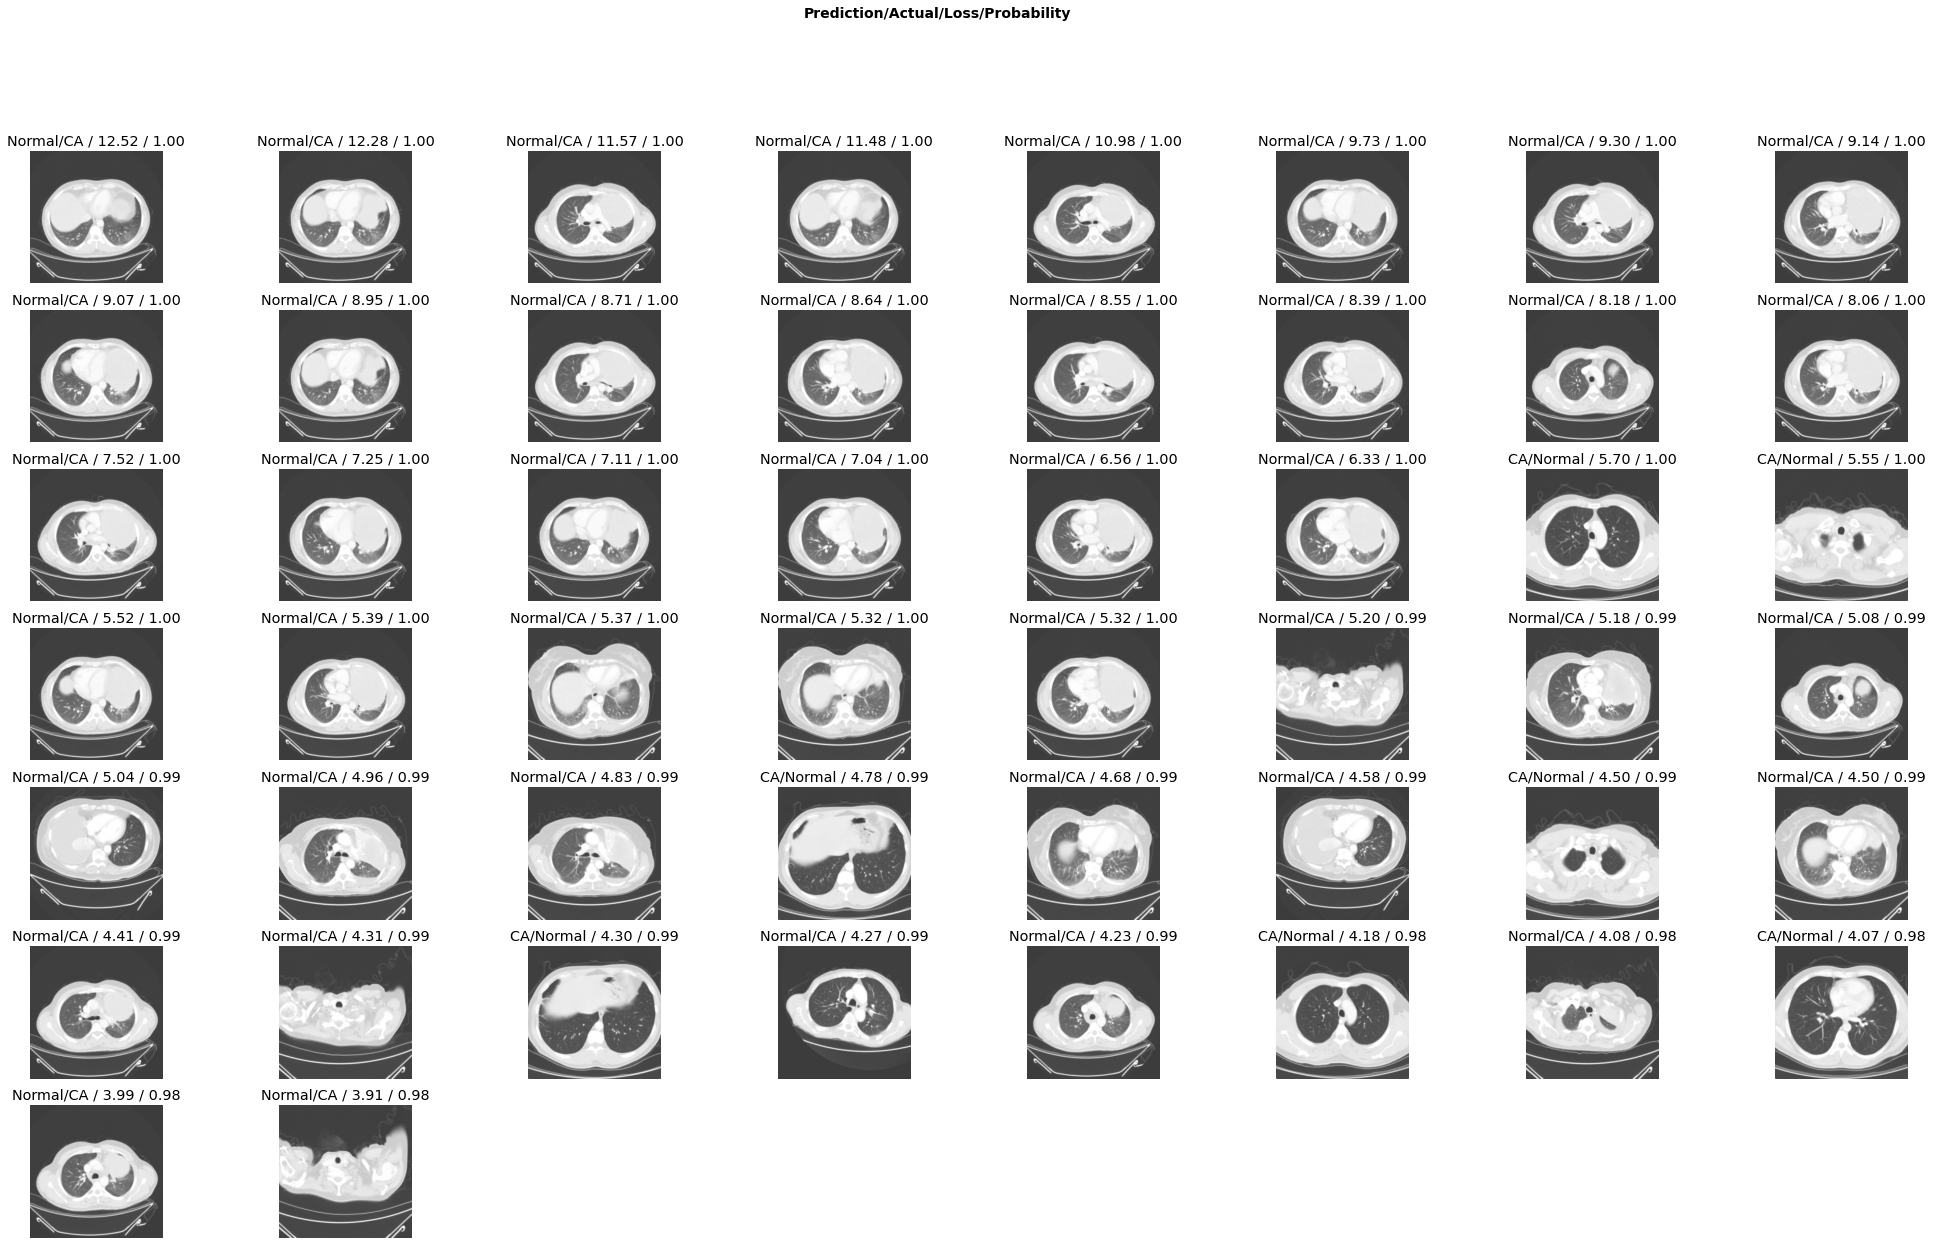

In [39]:
interp.plot_top_losses(50, figsize=(35,20))


In [45]:
losses,idxs = interp.top_losses(122)
print(idxs)

TensorBase([ 25,  55,  24, 117,  63,  68,  61, 113,  87, 125,  21,   9,  74,  40, 111,  89,  18, 135,  37,  72,   6,  10, 199, 202, 142,  51,  79,   3,  30, 131, 105, 114,  66, 106, 100, 322,   5,
            141, 259,  38, 101,  22, 446,  98,  81, 391,  93, 366,  75, 128,  39, 495, 299,  56,  84, 119,  42, 314,  57,  76, 337, 293,  17,  67, 110, 335,  59,  36, 458, 339, 444,  26,   7, 212,
            116,  60,  33,  64, 267,   4, 253, 123, 211, 198,  58,  43,  15, 220, 312, 127,  14,  90, 181, 527,  99, 291,  31,  29, 355, 324,  45, 183, 408, 507, 124, 278, 462, 162,  88, 221, 107,
             71,  83, 304, 171, 197,  11, 368, 258, 140, 132, 401])


In [41]:
dls_test.valid_ds.items[55]


Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/CA/IMG-0132-00046.bmp')

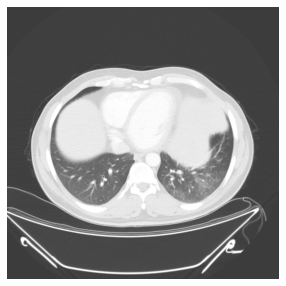

In [42]:
img = PILImage.create('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/CA/IMG-0132-00046.bmp')
img.show()

In [43]:
learn.predict(img)

('Normal', tensor(1), tensor([4.6570e-06, 1.0000e+00]))

In [46]:
dls_test.valid_ds.items[300]


Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/Normal/IMG-0132-00026.bmp')

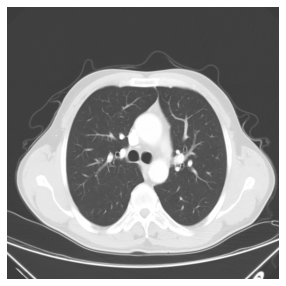

In [47]:
img = PILImage.create('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/Normal/IMG-0132-00026.bmp')
img.show()

In [48]:
learn.predict(img)

('Normal', tensor(1), tensor([0.0155, 0.9845]))

In [49]:
dls_test.valid_ds.items[56]


Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/CA/IMG-0122-00011.bmp')

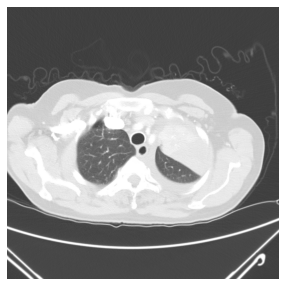

In [50]:
img = PILImage.create('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/CA/IMG-0122-00011.bmp')
img.show()

In [51]:
learn.predict(img)

('Normal', tensor(1), tensor([0.0235, 0.9765]))

In [54]:
dls_test.valid_ds.items[8]


Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/CA/IMG-0130-00019.bmp')

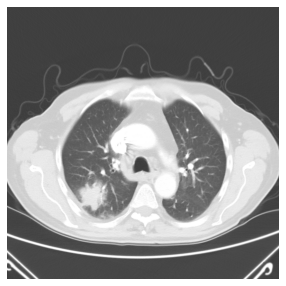

In [82]:
img = PILImage.create('/content/gdrive/MyDrive/LUNG_DATA adlı dosyanın kopyası/Lung_Binary_CA_Pneumonia/Test/CA/IMG-0130-00019.bmp')
img.show()

In [83]:
learn.predict(img)

('CA', tensor(0), tensor([0.9986, 0.0014]))

In [84]:
class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [85]:
m = learn1.model.eval()


In [86]:
target_layers = learn1.model[-1]

target_layers;

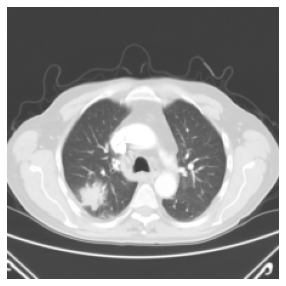

In [87]:
x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()
#CA

In [88]:
learn.predict(img)

('CA', tensor(0), tensor([0.9986, 0.0014]))

In [89]:
class_Z = 1

with HookGradient(target_layers) as hookg:
    with HookActivation(target_layers) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [90]:
w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()

IndexError: ignored

In [91]:
def plot_gradcam(img, learn1, hooked_layer, size=224):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))

TypeError: ignored

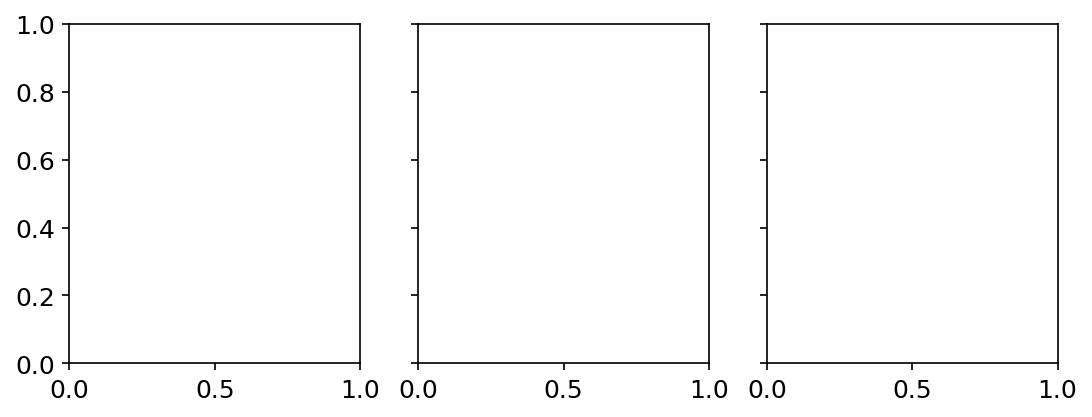

In [92]:
plot_gradcam(img,learn1,target_layers);